In [1]:
# basic 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime
import miceforest as mf

# pre-processing  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# feature selection 

# model building
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# performance
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

#### 1. Loading & basic checks

In [2]:
customer_data = pd.read_csv('zest_customers.csv')
loan_performance_data = pd.read_csv('zest_performance.csv')

In [3]:
# merging customer data with the loan performance data
customer_data['customer_id'] = customer_data['customer_id'].str.upper()
loan_performance_data['customer_id'] = loan_performance_data['idLoan'].str.split('-', expand = True)[0]
loan_counts = loan_performance_data.groupby('customer_id').count()['flgGood'].rename('num_loans')
default_loans = loan_performance_data[loan_performance_data.flgGood == 'Bad'].groupby('customer_id').count()['flgGood'].rename('num_defaults')
customer_data = customer_data.merge(right = loan_counts, how = 'left', on = 'customer_id').merge(right = default_loans, how = 'left', on = 'customer_id')
customer_data['num_loans'] = customer_data['num_loans'].fillna(0)
customer_data['num_defaults'] = customer_data['num_defaults'].fillna(0).astype('object')


In [4]:
# summary reveals some missing loans for the customers
customer_data.groupby(["num_loans", "num_defaults"]).size()

num_loans  num_defaults
0.0        0.0               7
1.0        0.0             273
           1.0             351
2.0        0.0              13
           1.0               3
dtype: int64

In [5]:
# removing customers with no target data
print("Size before removing no-loan data :", customer_data.shape)
customer_data = customer_data[customer_data.num_loans > 0]
print("Size after removing no-loan data :", customer_data.shape)

Size before removing no-loan data : (647, 33)
Size after removing no-loan data : (640, 33)


In [6]:
meta_dict = pd.DataFrame(customer_data.columns.to_list(), columns = ['Colname'])

# Adding metrics such as descriptions, missing rate, number of levels & data type of columns taken from the data dictionary
for idx, cols in enumerate(meta_dict.Colname):
    meta_dict.loc[idx, 'Missing_%'] = round(100*customer_data[cols].isna().sum()/customer_data.shape[0],2)
    meta_dict.loc[idx, 'Levels'] = customer_data[cols].nunique()
    meta_dict.loc[idx, 'Datatype'] = customer_data[cols].dtype
    meta_dict.loc[idx, 'Levels'] = customer_data[cols].nunique()

meta_dict

,Colname,Missing_%,Levels,Datatype
0,customer_id,0.00,640.0,object
1,amount_requested,0.00,11.0,int64
2,birth_date,0.00,621.0,object
3,status,0.00,1.0,object
4,residence_rent_or_own,0.00,2.0,bool
5,monthly_rent_amount,0.00,201.0,int64
6,bank_account_direct_deposit,0.00,2.0,bool
7,application_when,0.00,637.0,object
8,loan_duration,0.00,7.0,int64
9,payment_ach,0.00,2.0,bool


* Date columns are not in appropiate format. We will convert them into date-time format. 
* *Payment_amount_approved* and *other_phone_type* has missing values, so we will understand the nature (MAR/MCAR/NMAR) before imputing them
* *how_use_money* & *bank_account_duration* have just two observations missing, so we will drop those rows. 

In [7]:
# Understanding the various levels of important categorical features
for cols in customer_data.columns:
    if (customer_data[cols].dtype == 'object') & (customer_data[cols].nunique() <= 20):
        print(f'\nUnique levels for {cols}')
        print(customer_data[cols].unique())


Unique levels for status
['Approved']

Unique levels for email_duration
['1 year or more' '4-12 months' '3 months or less']

Unique levels for residence_duration
['6 months or less' '3+ years' '7-12 months' '1-2 years']

Unique levels for bank_account_duration
['6 months or less' '3+ years' '1-2 years' '7-12 months' nan]

Unique levels for payment_frequency
['Semi-monthly' 'Bi-weekly' 'Monthly' 'Weekly']

Unique levels for home_phone_type
['Mobile' 'Home' 'Work']

Unique levels for other_phone_type
[nan 'Home' 'Mobile' 'Work']

Unique levels for how_use_money
['Other' "Won't say" nan 'Bills' 'Car' 'Medical' 'Rent' 'Bills (General)'
 'Bills (Auto)' 'Bills (Medical)' 'Gifts / Leisure'
 'Pay off loans / overdrawn acct' 'Rent / Mortgage'
 'Bills (Home / Utilities)' 'School']

Unique levels for num_defaults
[0.0 1.0]


##### 1.2 Changing feature formats

In [8]:
customer_data['application_when'] = pd.to_datetime(customer_data['application_when'])
customer_data['application_month'] = customer_data['application_when'].dt.month
customer_data['birth_date'] = pd.to_datetime(customer_data['birth_date'])

def calculate_age(born):
    today = pd.to_datetime('31-12-2011 23:59')
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

customer_data['age'] = customer_data.birth_date.map(calculate_age)
customer_data['how_use_money'] = np.where(customer_data['how_use_money'].str.contains('Bills'), 'Bills', customer_data['how_use_money'])
customer_data['how_use_money'] = np.where(customer_data['how_use_money'].str.contains('Rent'), 'Rent', customer_data['how_use_money'])
customer_data['target'] = customer_data.num_defaults.astype('str')

In [9]:
customer_data

,customer_id,amount_requested,birth_date,status,residence_rent_or_own,monthly_rent_amount,bank_account_direct_deposit,application_when,loan_duration,payment_ach,num_payments,payment_amount,amount_approved,duration_approved,payment_amount_approved,address_zip,email,bank_routing_number,email_duration,residence_duration,bank_account_duration,payment_frequency,home_phone_type,other_phone_type,how_use_money,monthly_income_amount,raw_l2c_score,raw_FICO_telecom,raw_FICO_retail,raw_FICO_bank_card,raw_FICO_money,num_loans,num_defaults,application_month,age,target
0,9ECE67D6C5,500,1991-08-21,Approved,True,0,True,2010-10-16 14:06:00,3,True,6,138.48,500,3,NaN,84118,WanitaGVinyard@gmail.com,124001545,1 year or more,6 months or less,6 months or less,Semi-monthly,Mobile,NaN,Other,1560,614,574,600,656,561,1.0,0.0,10,20,0.0
1,5C2C402094,500,1990-07-24,Approved,True,0,False,2010-10-17 13:01:00,6,True,13,77.39,500,6,NaN,84062,NatashaTTucker@yahoo.com,124000054,1 year or more,3+ years,3+ years,Bi-weekly,Mobile,NaN,Other,900,708,501,550,651,563,1.0,1.0,10,21,1.0
2,E6254CAD30,400,1980-09-13,Approved,True,620,True,2010-10-17 19:52:00,6,True,13,61.91,400,6,NaN,84119,AnneDCisneros@hotmail.com,124001545,1 year or more,7-12 months,1-2 years,Bi-weekly,Mobile,NaN,Other,1434,687,522,561,661,598,1.0,0.0,10,31,0.0
3,49FB42F51D,500,1976-10-09,Approved,False,785,False,2010-10-18 07:05:00,4,True,8,108.48,500,4,NaN,84405,CatalinaRRoderick@hotmail.com,124002971,1 year or more,3+ years,7-12 months,Bi-weekly,Mobile,NaN,Other,1600,616,560,552,634,591,1.0,1.0,10,35,1.0
4,195FBE5739,300,1979-01-12,Approved,True,700,True,2010-10-19 10:58:00,4,True,8,65.09,300,4,NaN,84404,PhillipMSinn@aol.com,124002971,1 year or more,3+ years,6 months or less,Bi-weekly,Mobile,Home,Other,1360,681,603,654,659,636,1.0,0.0,10,32,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,0AEED95009,300,1981-10-15,Approved,True,0,True,2011-04-16 18:45:00,3,True,6,83.09,300,3,83.09,84065,LanaTMcClain@aol.com,124002971,1 year or more,3+ years,3+ years,Semi-monthly,Mobile,Work,Other,1600,616,583,591,680,622,1.0,1.0,4,30,1.0
643,755F6707C9,800,1946-06-03,Approved,True,529,True,2011-04-16 21:48:00,8,True,8,231.76,800,8,231.76,84116,BrianMSmith@bing.com,324079555,1 year or more,7-12 months,3+ years,Monthly,Mobile,Work,Other,2050,583,612,649,659,628,1.0,0.0,4,65,0.0
644,9E9CA8F361,800,1976-05-25,Approved,True,900,True,2011-04-17 11:24:00,8,True,13,77.39,500,6,77.39,84029,ElizabethNTester@gmail.com,124001545,1 year or more,7-12 months,6 months or less,Bi-weekly,Mobile,NaN,Bills,3626,573,543,556,657,588,1.0,0.0,4,35,0.0
645,0F7B7C2C37,500,1960-09-06,Approved,True,650,True,2011-04-17 12:06:00,5,True,10,94.70,500,5,94.70,83858,GeraldTGish@bing.com,123103716,1 year or more,1-2 years,3+ years,Semi-monthly,Mobile,Work,Bills,1800,329,571,616,650,618,1.0,1.0,4,51,1.0


##### 1.3 Adding additional features

In [10]:
#customer_data['payment_amount_approved'] = np.where(customer_data['payment_amount_approved'].isna(), \
#    customer_data['payment_amount'], customer_data['payment_amount_approved'])
# Total payments is the product of num_payments and the payment_amount
customer_data['total_expected_payment'] = customer_data['num_payments'] * customer_data['payment_amount_approved']  
customer_data['simple_interest_rate'] = (customer_data['total_expected_payment'] - customer_data['amount_approved'])/customer_data['amount_approved']
customer_data['rent_to_income_ratio'] = customer_data['monthly_rent_amount']/customer_data['monthly_income_amount']

def emi_calculator(payment_freq, payment_amt):
    if payment_freq in ['Bi-weekly', 'Semi-monthly']:
        return payment_amt * 2
    elif payment_freq == 'Weekly':
        return payment_amt * 4
    else:
        return payment_amt

customer_data['emi'] = customer_data.apply(lambda x : emi_calculator(x['payment_frequency'], x['payment_amount_approved']), axis  = 1)
customer_data['loan_to_income_ratio'] = customer_data['emi']/customer_data['monthly_income_amount']
customer_data['FOIR'] = (customer_data['emi'] + customer_data['monthly_rent_amount'])/customer_data['monthly_income_amount']


# FICO scores
customer_data['mean_FICO'] = customer_data[['raw_FICO_telecom','raw_FICO_retail', 'raw_FICO_bank_card', 'raw_FICO_money']].mean(axis=1)
#(customer_data.raw_FICO_telecom + customer_data.raw_FICO_retail + customer_data.raw_FICO_bank_card + customer_data.raw_FICO_money)/4
customer_data['min_FICO'] = customer_data[['raw_FICO_telecom','raw_FICO_retail', 'raw_FICO_bank_card', 'raw_FICO_money']].min(axis=1)

In [11]:
customer_data.columns

Index(['customer_id', 'amount_requested', 'birth_date', 'status',
       'residence_rent_or_own', 'monthly_rent_amount',
       'bank_account_direct_deposit', 'application_when', 'loan_duration',
       'payment_ach', 'num_payments', 'payment_amount', 'amount_approved',
       'duration_approved', 'payment_amount_approved', 'address_zip', 'email',
       'bank_routing_number', 'email_duration', 'residence_duration',
       'bank_account_duration', 'payment_frequency', 'home_phone_type',
       'other_phone_type', 'how_use_money', 'monthly_income_amount',
       'raw_l2c_score', 'raw_FICO_telecom', 'raw_FICO_retail',
       'raw_FICO_bank_card', 'raw_FICO_money', 'num_loans', 'num_defaults',
       'application_month', 'age', 'target', 'total_expected_payment',
       'simple_interest_rate', 'rent_to_income_ratio', 'emi',
       'loan_to_income_ratio', 'FOIR', 'mean_FICO', 'min_FICO'],
      dtype='object')

##### 1.4 Removing irrelevant variables

In [12]:
irrelevant_cols = ['customer_id', 'amount_requested', 'birth_date', 'status', 'application_when', 'loan_duration',
'payment_ach', 'payment_amount', 'address_zip', 'email', 'bank_routing_number', 'home_phone_type', 'other_phone_type', 'application_month', 'age']

customer_data = customer_data.drop(irrelevant_cols, axis = 1)

In [13]:
customer_data.columns

Index(['residence_rent_or_own', 'monthly_rent_amount',
       'bank_account_direct_deposit', 'num_payments', 'amount_approved',
       'duration_approved', 'payment_amount_approved', 'email_duration',
       'residence_duration', 'bank_account_duration', 'payment_frequency',
       'how_use_money', 'monthly_income_amount', 'raw_l2c_score',
       'raw_FICO_telecom', 'raw_FICO_retail', 'raw_FICO_bank_card',
       'raw_FICO_money', 'num_loans', 'num_defaults', 'target',
       'total_expected_payment', 'simple_interest_rate',
       'rent_to_income_ratio', 'emi', 'loan_to_income_ratio', 'FOIR',
       'mean_FICO', 'min_FICO'],
      dtype='object')

#### 2.0 Feature Information

##### 2.1 Distribution & Target rates of independent variables

I have created a module that takes in DataFrame, input features & the target variable before creating basic information graphs. 
* For categorical variables, their distribution % are represented using bars while the average target rate is represented using scatter points. 
* For numerical variables, their distribution is represented using density plots with the target variable as a grouped hue. 


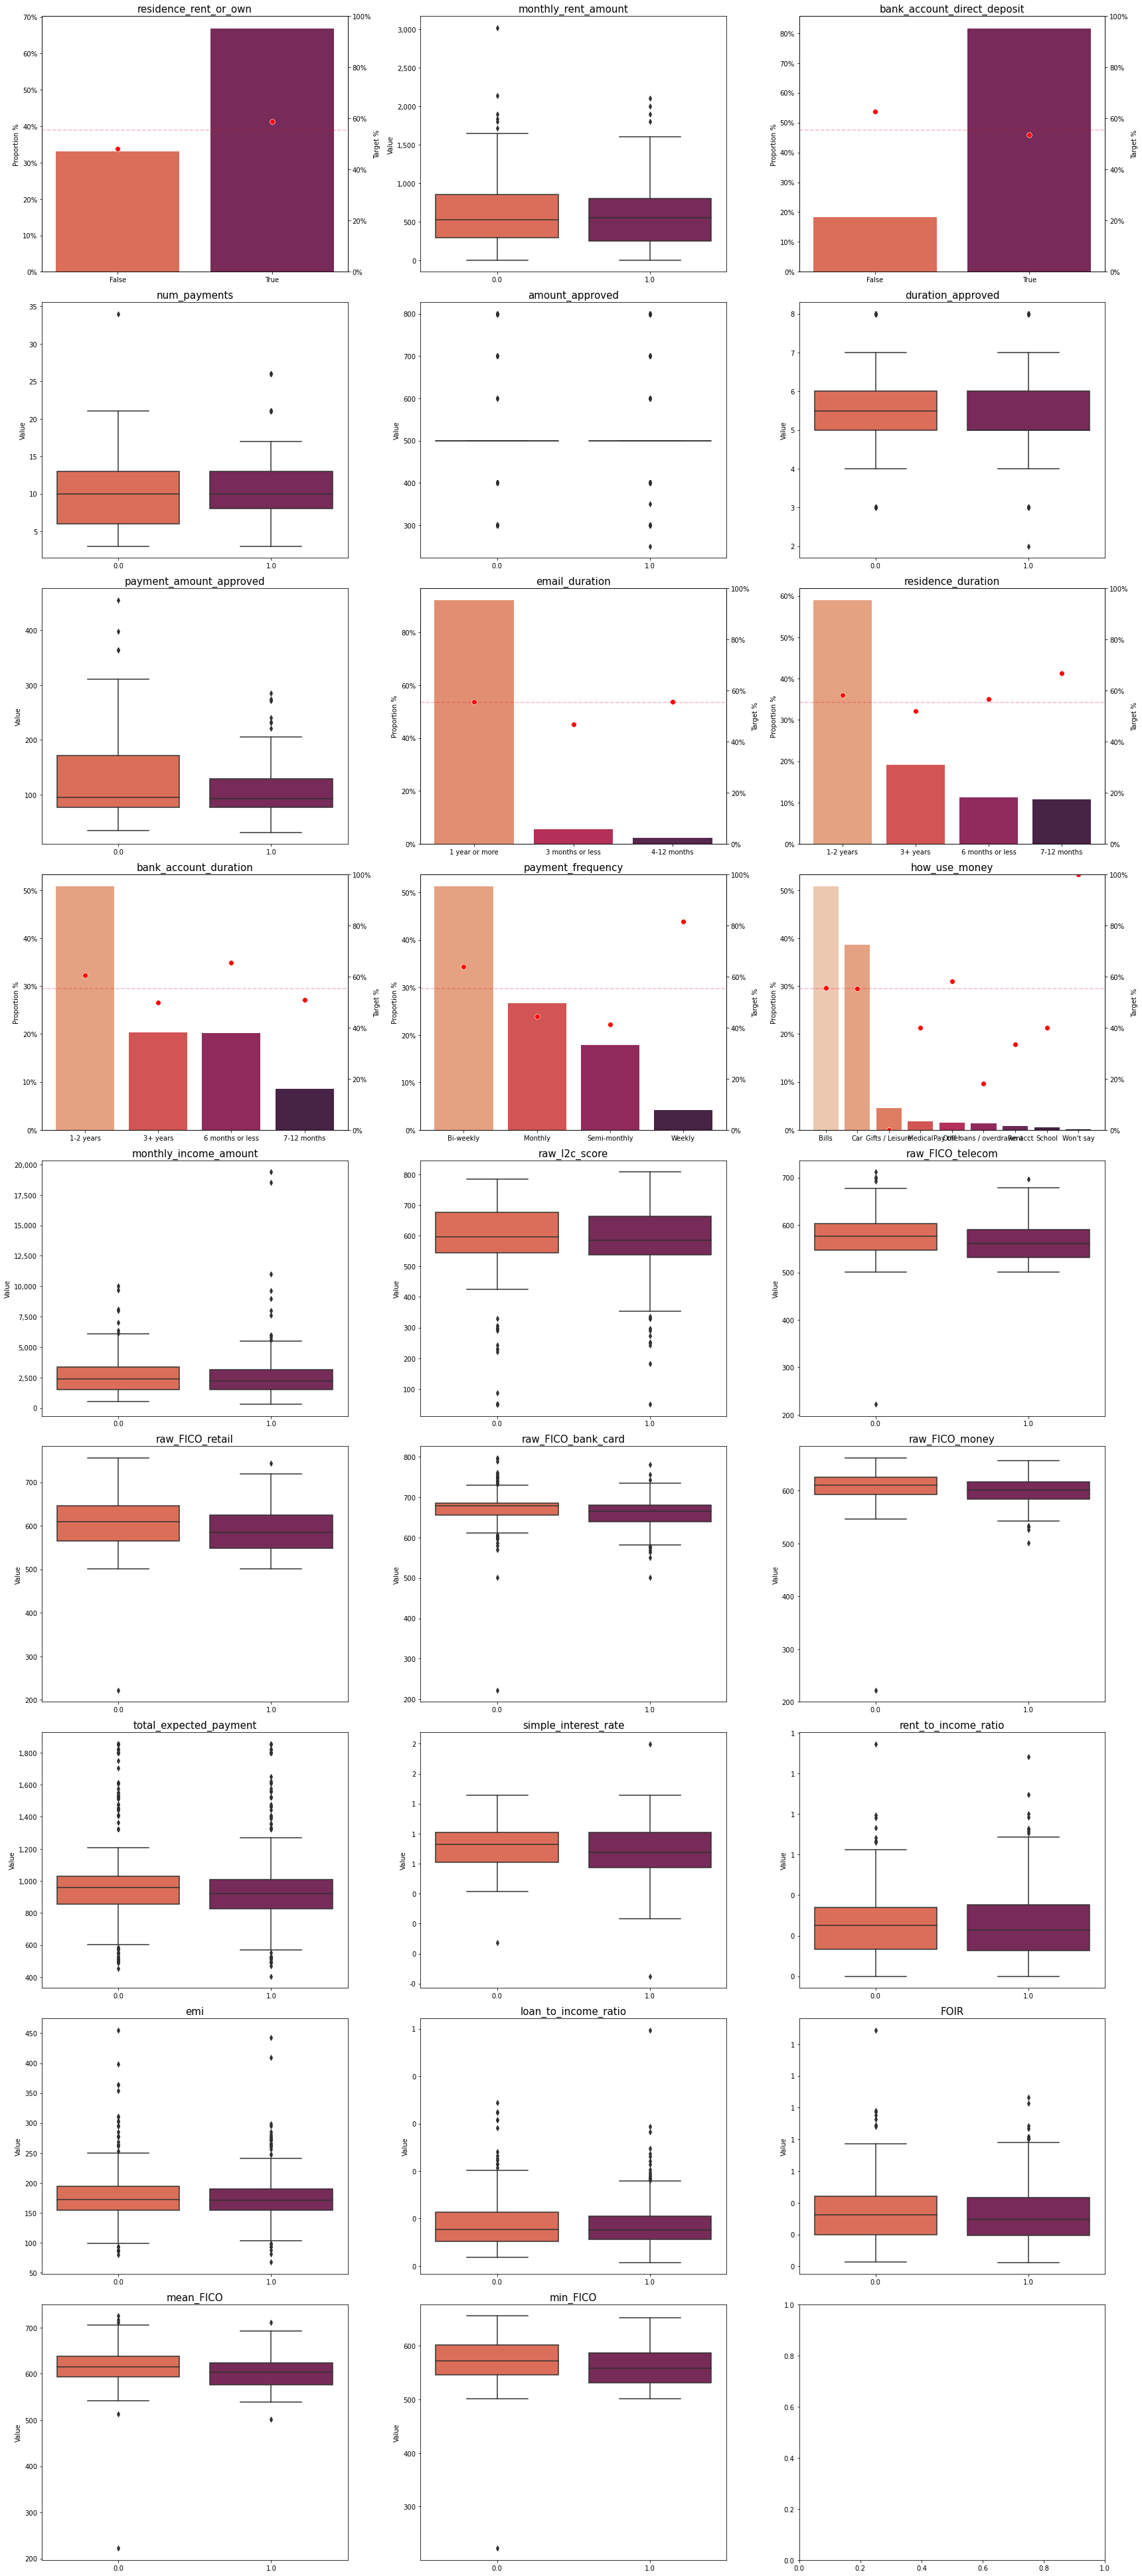

In [14]:
from preprocessing import FeatureDescription

input_features = customer_data.drop(['target', 'num_defaults', 'num_loans'], axis = 1).columns.to_list()
#customer_data.drop(['customer_id', 'status', 'application_when', 'bank_routing_number', 
                  #                  'birth_date', 'address_zip', 'email', 'num_loans', 'num_defaults', 'target'], axis = 1).columns.to_list()
feature_description = FeatureDescription(input_data = customer_data , 
                                        feature_list = input_features, 
                                        target = 'target')

feature_description.plot(numerical_plot_type= 'box')

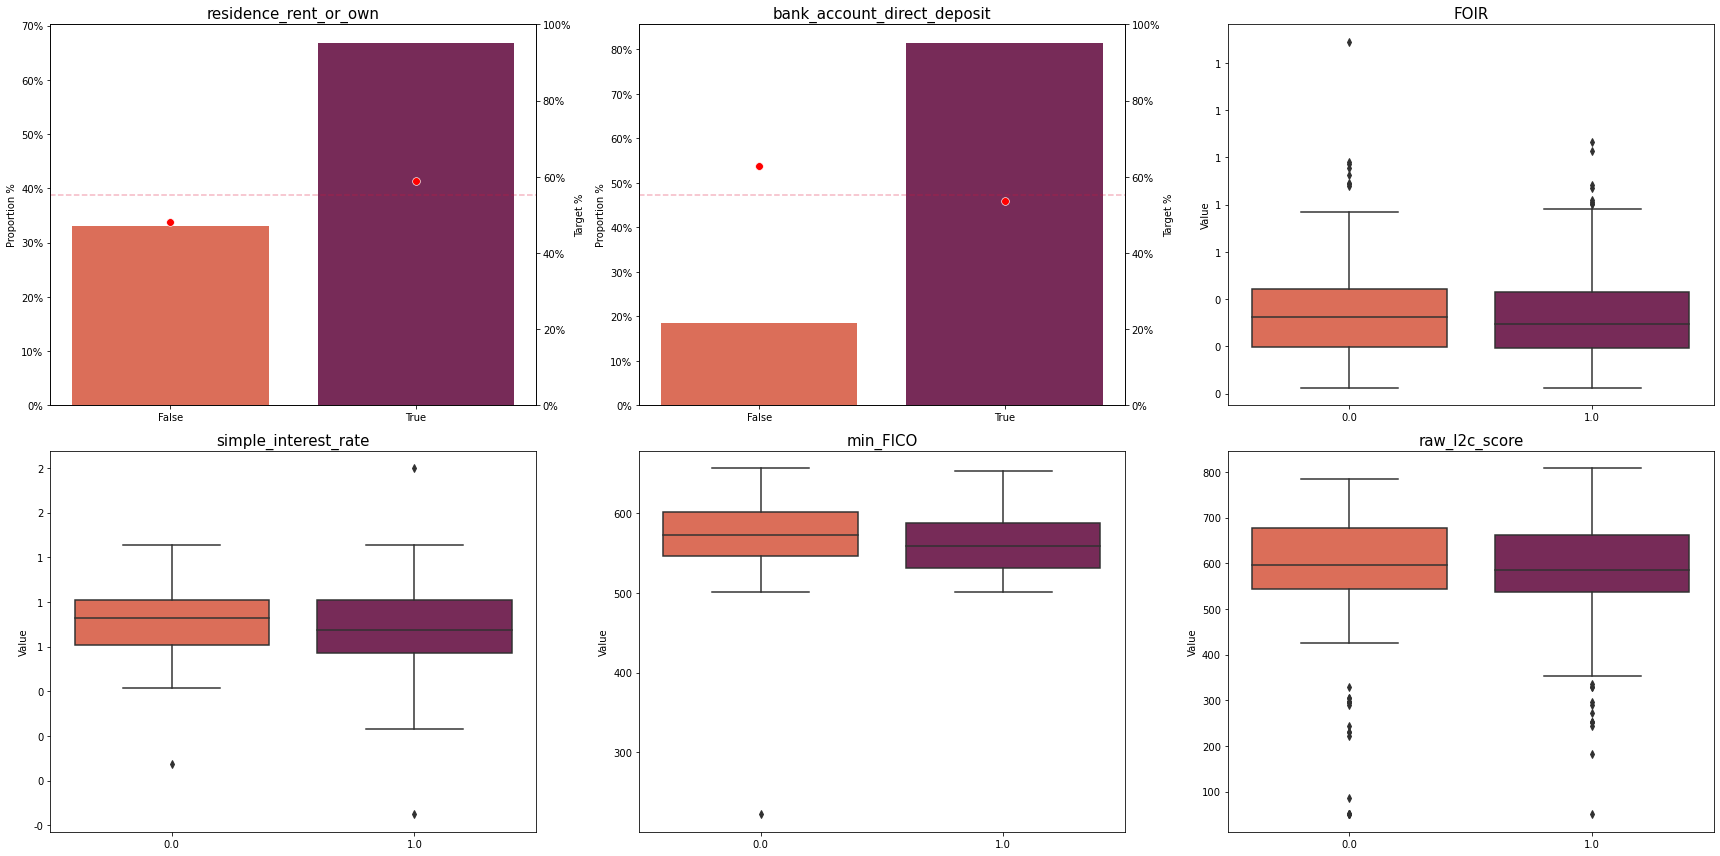

In [15]:
from preprocessing import FeatureDescription

best_input_features = ['residence_rent_or_own', 'bank_account_direct_deposit', 'FOIR', 'simple_interest_rate', 'min_FICO','raw_l2c_score']
feature_description = FeatureDescription(input_data = customer_data , 
                                        feature_list = best_input_features, 
                                        target = 'target')

feature_description.plot(numerical_plot_type= 'box')

##### 2.2 Univariate checks
In this section, I have used two methods to estimate the feature information in our data. The methods are interchangeable. In the basic method, we use statistical tests to ascertain the information available in a single feature. 
* Since this is a classification task, numerical variables are run through ANOVA test of variance which uses the F-statistic
* For categorical variables, we use a Chi-square test using contingent tables to understand its importance. 

The top 10 features under each categorical are then plotted in decreasing absolute magnitude of information. 

Another way of doing the same is to use LightGBM model with default parameters on a single feature to estimate the AUC. Higher the AUC, more information is stored in the feature. LightGBM is well suited for this task because of its ability to use GOSS & EFB to speed up the process as well handling categorical variables automatically. 

Other tree based methods such as XGB & Random Forests on paper can also deal with categorical data but the sklearn module widely used in Python does not support this. 


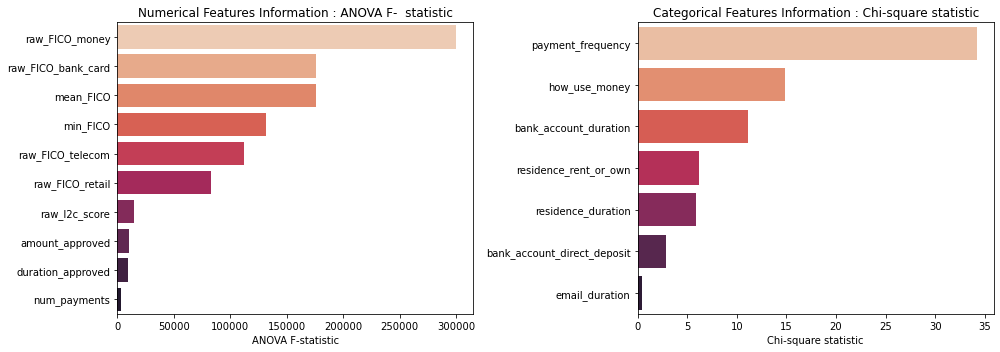

In [16]:
from preprocessing import FeatureInformation

feature_imp = FeatureInformation(input_data = customer_data , 
                                        feature_list = input_features, 
                                        target = 'target', 
                                        method = 'basic')
feature_imp.plot()

Feature information using LightGBM

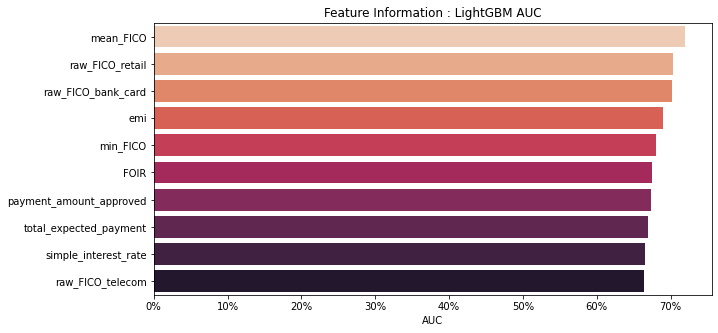

In [17]:
feature_imp = FeatureInformation(input_data = customer_data , 
                                        feature_list = input_features, 
                                        target = 'target', 
                                        method = 'lgbm')
feature_imp.plot()

#### 3.0 Pre-processing

Before training the data using classification models, we will need to pre-process the data. This includes imputing missing values, outlier detection, standardization & categorical feature handling. 

##### 3.1 Missing value imputation

Only three variables have some missing values in the data. 
1. *Payment Amount Approved* : We will use MICE to impute missing values since the feature turns out to be useful (high AUC in LBGM check) & the proportion of missing values is not too high.
2. *How use Money* contains 0.4% of missing values, however since it is not a lot, we will simply impute them with the mode. Another way of dealing with this is to remove the observations with missing values or create a separate segment. 
3. *Other Phone Type* contains more than 40% missing values. It does not contain a lot of information for our modelling as well. Based on the prelimnary check, it is likely to be a MCAR (Missing Conditionally at Random). Customers with secondary phone won't fill it this data, so we can skip this column altogether. 

In [18]:
# removing observations with missing "how_use_money" values
customer_data = customer_data[~customer_data.how_use_money.isna()]
customer_data = customer_data[~customer_data.bank_account_duration.isna()]

In [19]:
# MICE can only work with category as the format 
for cols in customer_data.columns:
    if customer_data[cols].dtype == 'object':
        customer_data[cols] = customer_data[cols].astype('category')


# Create kernels. 
kernel = mf.ImputationKernel(
  data=customer_data[input_features],
  save_all_iterations=True,
  random_state=1991
)
# Run the MICE algorithm for 5 iterations on each of the datasets
kernel.mice(5,verbose=True)
customer_data_completed = kernel.complete_data()

Initialized logger with name mice 1-5
Dataset 0
1  | payment_amount_approved | total_expected_payment | simple_interest_rate | emi | loan_to_income_ratio | FOIR
2  | payment_amount_approved | total_expected_payment | simple_interest_rate | emi | loan_to_income_ratio | FOIR
3  | payment_amount_approved | total_expected_payment | simple_interest_rate | emi | loan_to_income_ratio | FOIR
4  | payment_amount_approved | total_expected_payment | simple_interest_rate | emi | loan_to_income_ratio | FOIR
5  | payment_amount_approved | total_expected_payment | simple_interest_rate | emi | loan_to_income_ratio | FOIR


In [20]:
customer_data_completed.isna().sum()

residence_rent_or_own          0
monthly_rent_amount            0
bank_account_direct_deposit    0
num_payments                   0
amount_approved                0
duration_approved              0
payment_amount_approved        0
email_duration                 0
residence_duration             0
bank_account_duration          0
payment_frequency              0
how_use_money                  0
monthly_income_amount          0
raw_l2c_score                  0
raw_FICO_telecom               0
raw_FICO_retail                0
raw_FICO_bank_card             0
raw_FICO_money                 0
total_expected_payment         0
simple_interest_rate           0
rent_to_income_ratio           0
emi                            0
loan_to_income_ratio           0
FOIR                           0
mean_FICO                      0
min_FICO                       0
dtype: int64

##### 3.2 Outlier Detection

Having outliers in the data might be a bit risky, especially when working with scale sensiitive classification models. There are multiple ways of detecting & dealing with outliers such as :

* Interquartile distance : A valid representation of 'valid' range for numerical numbers can be derived using a multiplier on the IQR which is defined as the range between the 25th & 75th quantile. This multiplier is usually chosen as 1.5 because it represents ~3 standard deviations or 99% under the normal distribution assumption. We will simply look at that method to identify the extent of outliers within each numerical feature. 

    * A similar method to this is to simply look at the percentile values and winsorize 99%/1% (other something similar)
    * Outliers can also be dealt with by removing the observations that falls outside our definition of valid. 

* I-forest: One shortcoming of using IQR for univariate outliers is that often in real life, we encounter observations that are not outliers wrt a particular variable but when considered with ALL of them. For example, a person earning 200k or a person with an age of 17 is not unusual. But a teenager earning 200k is very unusual. So, we will build a Isolation forest (a popular method for Anamaly detection) to identify outliers. The detected outliers are then removed. 

In this below section, I utilize my own class *OutlierDetection* to follow the steps method above. 

In [21]:
from preprocessing import OutlierDetection

outlier_detection = OutlierDetection(input_data = customer_data_completed , 
                                    feature_list = input_features, 
                                    method = 'iqr')
customer_data_outliers = outlier_detection.identify(verbose = True, cap = False)

Number of outliers detected for monthly_rent_amount is 10
Number of outliers detected for num_payments is 6
Number of outliers detected for amount_approved is 219
Number of outliers detected for duration_approved is 120
Number of outliers detected for payment_amount_approved is 31
Number of outliers detected for monthly_income_amount is 25
Number of outliers detected for raw_l2c_score is 32
Number of outliers detected for raw_FICO_telecom is 6
Number of outliers detected for raw_FICO_retail is 1
Number of outliers detected for raw_FICO_bank_card is 41
Number of outliers detected for raw_FICO_money is 5
Number of outliers detected for total_expected_payment is 130
Number of outliers detected for simple_interest_rate is 3
Number of outliers detected for rent_to_income_ratio is 15
Number of outliers detected for emi is 61
Number of outliers detected for loan_to_income_ratio is 29
Number of outliers detected for FOIR is 16
Number of outliers detected for mean_FICO is 8
Number of outliers d

Identifying & removing outliers using I-Forest trees

In [22]:
outlier_detection = OutlierDetection(input_data = customer_data_completed , 
                                    feature_list = input_features, 
                                    method = 'iforest')
customer_data_outliers = outlier_detection.identify(verbose = True)
customer_data_clean = outlier_detection.remove(customer_data_outliers)
customer_data_clean.shape

Number of outliers observations removed is 32 out of 639 observations


(607, 26)

##### 3.3 Train-Test split

In [23]:
#customer_data_clean_v2 = customer_data_clean.merge(customer_data[['target']], left_index=True, right_index=True)

X = customer_data_clean #customer_data_clean_v2.drop('target', axis = 1)
y = customer_data[customer_data.index.isin(customer_data_clean.index)].reindex(customer_data_clean.index).target #customer_data_clean_v2.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25, random_state=42)

X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

le_train = LabelEncoder()
y_train = le_train.fit_transform(y_train)
le_test = LabelEncoder()
y_test = le_test.fit_transform(y_test)

In [24]:
print(y_train.mean(), y_test.mean())

0.5604395604395604 0.5592105263157895


##### 3.4 Standardization & OHE pipeline

* Standardization is the process of scaling variables in the data to a similar range. This is particularly useful when we use models that are sensitive to scales, such as the logistic regression with regualarization. Since we will try out some baseline models to create benchmarks, we will standardize our numerical variables. 

    * There are multiple methods available such as StandardScaler (fitting a normal distribution), MinMaxScaler(using min and max to scale values between 0 to 1) or RobustScaler(uses 25th & 75th percentile to scale).

* For categorical features, we will make them machine readable by converting them into dummies using the One Hot encoders. 
* We will use a ML Pipeline to make this preprocessing cleaner. This also helps in ensuring there are no data leakage and provides an option to tune any hyperparameters wrt to the preprocessing as well. 

In [25]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_features = X_train.select_dtypes(include=numerics).columns.to_list()
categorical_features = X_train.select_dtypes(exclude=numerics).columns.to_list()

num_transformer = StandardScaler().fit(X_train[numerical_features])
X_train_numeric = pd.DataFrame(num_transformer.transform(X_train[numerical_features]), columns = numerical_features)
X_test_numeric = pd.DataFrame(num_transformer.transform(X_test[numerical_features]), columns = numerical_features)

In [26]:
ohe_transformer = OneHotEncoder(drop = 'first', sparse = False).fit(X_train[categorical_features])
X_train_categorical = pd.DataFrame(ohe_transformer.transform(X_train[categorical_features]), 
                            columns = ohe_transformer.get_feature_names(categorical_features))
X_test_categorical = pd.DataFrame(ohe_transformer.transform(X_test[categorical_features]), 
                            columns = ohe_transformer.get_feature_names(categorical_features))

In [27]:
X_train_processed = pd.concat([X_train_numeric, X_train_categorical], axis = 1)
X_test_processed = pd.concat([X_test_numeric, X_test_categorical], axis = 1)
print(X_train.shape, X_test.shape)
print(X_train_processed.shape, X_test_processed.shape)

(455, 26) (152, 26)
(455, 40) (152, 40)


In [28]:
# def report_classification_metrics(y_train : pd.Series, y_preds_train : pd.Series, y_test : pd.Series, y_preds_test : pd.Series):
#     from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
#     print('Train set results')
#     print(f'Accuracy  : {accuracy_score(y_train, y_preds_train) : .2%}')
#     print(f'Precision : {precision_score(y_train, y_preds_train): .2%}')
#     print(f'Recall    : {recall_score(y_train, y_preds_train): .2%}')
#     print(f'F1-score  : {f1_score(y_train, y_preds_train): .2%}')
#     print(f'ROC AUC   : {roc_auc_score(y_train, y_preds_train): .2%}')
#     print('\nTest set results')
#     print(f'Accuracy  : {accuracy_score(y_test, y_preds_test) : .2%}')
#     print(f'Precision : {precision_score(y_test, y_preds_test): .2%}')
#     print(f'Recall    : {recall_score(y_test, y_preds_test): .2%}')
#     print(f'F1-score  : {f1_score(y_test, y_preds_test): .2%}')
#     print(f'ROC AUC   : {roc_auc_score(y_test, y_preds_test): .2%}')


# def get_model_results(df, model):
#     return pd.DataFrame(zip(df.columns, np.transpose(model.coef_[0])), columns=['features', 'coef']) 

<AxesSubplot:>

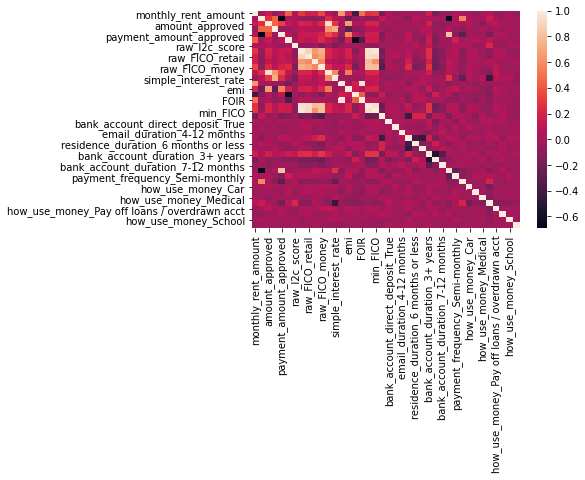

In [31]:
sns.heatmap(X_train_processed.corr())

In [ ]:
def report_classification_metrics(X_train, y_train, X_test, y_test, model):
    from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc

    yhat_train = model.predict_proba(X_train_processed)[:,1] 
    precision, recall, thresholds = precision_recall_curve(y_train, yhat_train)
    best_accuracy, best_accuracy_threshold, best_f1, best_f1_threshold = 0, 0, 0, 0
    for t in thresholds:
        ypreds_train = [1 if yhat > t else 0 for yhat in yhat_train] #1 if yhat_train > t else 0
        accuracy = accuracy_score(y_train, ypreds_train) # (TP + TN)/(TP + FP + TN + FN)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_accuracy_threshold = t
        f1 = f1_score(y_train, ypreds_train)
        if f1 > best_f1:
            best_f1 = f1
            best_f1_threshold = t


    print('Train set results')
    print(f'Accuracy  : {best_accuracy : .2%}')
    print(f'F1-score  : {best_f1: .2%}')
    print(f'ROC AUC   : {roc_auc_score(y_train, yhat_train): .2%}')
    print(f'AUPRC     : {auc(recall, precision): .2%}')
    
    yhat_test = model.predict_proba(X_test_processed)[:,1]
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, yhat_test)
    ypreds_test_best_accuracy = [1 if yhat > best_accuracy_threshold else 0 for yhat in yhat_test]
    ypreds_test_best_f1 = [1 if yhat > best_f1_threshold else 0 for yhat in yhat_test]
    
    print('\nTest set results')
    print(f'Accuracy  : {accuracy_score(y_test, ypreds_test_best_accuracy) : .2%}')
    print(f'F1-score  : {f1_score(y_test, ypreds_test_best_f1): .2%}')
    print(f'ROC AUC   : {roc_auc_score(y_test, yhat_test): .2%}')
    print(f'AUPRC     : {auc(recall_test, precision_test): .2%}')

def get_model_results(df, model):
    return pd.DataFrame(zip(df.columns, np.transpose(model.coef_[0])), columns=['features', 'coef']) 

##### 4.1 Baseline Classification Model : Logistic Regression

In [30]:
# lr_base = LogisticRegression(random_state = 42).fit(X_train_processed, y_train)
# report_classification_metrics(y_train, lr_base.predict(X_train_processed), y_test, lr_base.predict(X_test_processed))

In [31]:
lr_base = LogisticRegression(random_state = 42).fit(X_train_processed, y_train)
report_classification_metrics(X_train_processed, y_train, X_test_processed, y_test, lr_base)

Train set results
Accuracy  :  66.59%
F1-score  :  74.77%
ROC AUC   :  71.46%
AUPRC     :  75.14%

Test set results
Accuracy  :  63.16%
F1-score  :  72.90%
ROC AUC   :  67.25%
AUPRC     :  71.80%


In [32]:
get_model_results(X_train_processed, lr_base)

,features,coef
0,monthly_rent_amount,0.136136
1,num_payments,-0.274430
2,amount_approved,0.309121
3,duration_approved,0.564551
4,payment_amount_approved,-0.579392
5,monthly_income_amount,0.149494
6,raw_l2c_score,-0.043208
7,raw_FICO_telecom,0.393808
8,raw_FICO_retail,-0.200019
9,raw_FICO_bank_card,-0.136507


##### 4.1.2 Hyper-parameter tuning using RFE & GridSearch

In [33]:
lr_base.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [36]:
params = {
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1],
    #'class_weight' : [None],
    'max_iter' : [25, 50, 75, 100, 250]
}

rskf = RepeatedStratifiedKFold(n_splits = 50 , n_repeats = 2, random_state = 42)
logreg_cv = GridSearchCV(
  LogisticRegression(random_state = 42), params, 
  cv = rskf, 
  scoring = 'roc_auc',
  verbose = True
  )

logreg_cv.fit(X_train_processed, y_train)
print(f'Best AUC-score: {logreg_cv.best_score_:.3f}\n')
print(f'Best parameter set: {logreg_cv.best_params_}\n')
print(f'Scores: \n{classification_report(y_train, logreg_cv.predict(X_train_processed))}')
#report_classification_metrics(y_train, logreg_cv.predict(X_train_processed), y_test, logreg_cv.predict(X_test_processed))
report_classification_metrics(X_train_processed, y_train, X_test_processed, y_test, logreg_cv.best_estimator_)

Fitting 100 folds for each of 80 candidates, totalling 8000 fits
Best AUC-score: 0.616

Best parameter set: {'C': 0.001, 'max_iter': 25, 'penalty': 'l2', 'solver': 'lbfgs'}

Scores: 
              precision    recall  f1-score   support

           0       0.68      0.13      0.22       199
           1       0.59      0.95      0.73       256

    accuracy                           0.59       455
   macro avg       0.63      0.54      0.47       455
weighted avg       0.63      0.59      0.50       455

Train set results
Accuracy  :  62.20%
F1-score  :  73.28%
ROC AUC   :  64.02%
AUPRC     :  69.49%

Test set results
Accuracy  :  64.47%
F1-score  :  73.28%
ROC AUC   :  63.11%
AUPRC     :  64.01%


In [35]:
logreg_cv.best_estimator_.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 25,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

4.1.2 Optuna Bayesian Optimization

In [93]:
import optuna
from sklearn import model_selection

#Step 1. Define an objective function to be maximized.
def objective(trial):
    
    # Setup values for the hyperparameters:
    logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
    iterations = trial.suggest_int("iterations", 25, 500, log=True)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    classifier_obj = LogisticRegression(C=logreg_c, 
                                        max_iter = iterations, 
                                        penalty = 'l2',
                                        random_state= 42)

    # Step 3: Scoring method:
    score = model_selection.cross_val_score(classifier_obj, X_train_processed, y_train, n_jobs=-1, cv=10, scoring = 'roc_auc')
    auc = score.mean()
    return auc

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-10-30 14:43:50,701] A new study created in memory with name: no-name-6f413364-0dc3-4505-a2ed-cf569d99ebd0
[I 2022-10-30 14:43:54,496] Trial 0 finished with value: 0.6165599190283401 and parameters: {'logreg_c': 0.043445348524709076, 'iterations': 250, 'penalty': 'l1'}. Best is trial 0 with value: 0.6165599190283401.
[I 2022-10-30 14:43:54,605] Trial 1 finished with value: 0.616523076923077 and parameters: {'logreg_c': 20602331.48321321, 'iterations': 126, 'penalty': 'l2'}. Best is trial 0 with value: 0.6165599190283401.
[I 2022-10-30 14:43:54,718] Trial 2 finished with value: 0.6166348178137652 and parameters: {'logreg_c': 7.780906642912614, 'iterations': 433, 'penalty': 'l1'}. Best is trial 2 with value: 0.6166348178137652.
[I 2022-10-30 14:43:54,802] Trial 3 finished with value: 0.6147210526315788 and parameters: {'logreg_c': 0.35972364404324353, 'iterations': 269, 'penalty': 'l2'}. Best is trial 2 with value: 0.6166348178137652.
[I 2022-10-30 14:43:54,893] Trial 4 finished w

In [94]:
# Getting the best trial:
print(f"\nThe best trial is : \n{study.best_trial}")
print(f"\nThe best value is : \n{study.best_value}")

# Getting the best parameters:
print(f"\nThe best parameters are : \n{study.best_params}")


The best trial is : 
FrozenTrial(number=62, values=[0.6219230769230769], datetime_start=datetime.datetime(2022, 10, 30, 14, 43, 59, 464014), datetime_complete=datetime.datetime(2022, 10, 30, 14, 43, 59, 528116), params={'logreg_c': 1.9218937699252428e-05, 'iterations': 160, 'penalty': 'l2'}, distributions={'logreg_c': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None), 'iterations': IntDistribution(high=500, log=True, low=25, step=1), 'penalty': CategoricalDistribution(choices=('l1', 'l2'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=62, state=TrialState.COMPLETE, value=None)

The best value is : 
0.6219230769230769

The best parameters are : 
{'logreg_c': 1.9218937699252428e-05, 'iterations': 160, 'penalty': 'l2'}


In [95]:
optuna_logreg = LogisticRegression(random_state = 42, max_iter = 160, penalty = 'l2', C = 1.9218937699252428e-05).fit(X_train_processed, y_train)
report_classification_metrics(X_train = X_train_processed, 
                            y_train = y_train, 
                            X_test = X_test_processed, 
                            y_test = y_test, 
                            model = optuna_logreg)

Train set results
Accuracy  :  63.52%
F1-score  :  72.90%
ROC AUC   :  63.55%
AUPRC     :  67.70%

Test set results
Accuracy  :  60.53%
F1-score  :  72.30%
ROC AUC   :  60.73%
AUPRC     :  65.42%


##### 4.2 Decision Trees



In [139]:
from sklearn.tree import export_graphviz 
dtree_base = DecisionTreeClassifier(random_state=42).fit(X_train_processed, y_train)
#report_classification_metrics(y_train, dtree_base.predict(X_train_processed), y_test, dtree_base.predict(X_test_processed))
report_classification_metrics(X_train_processed, y_train, X_test_processed, y_test, dtree_base)

Train set results
Accuracy  :  100.00%
F1-score  :  100.00%
ROC AUC   :  100.00%
AUPRC     :  100.00%

Test set results
Accuracy  :  59.21%
F1-score  :  62.20%
ROC AUC   :  59.10%
AUPRC     :  73.46%


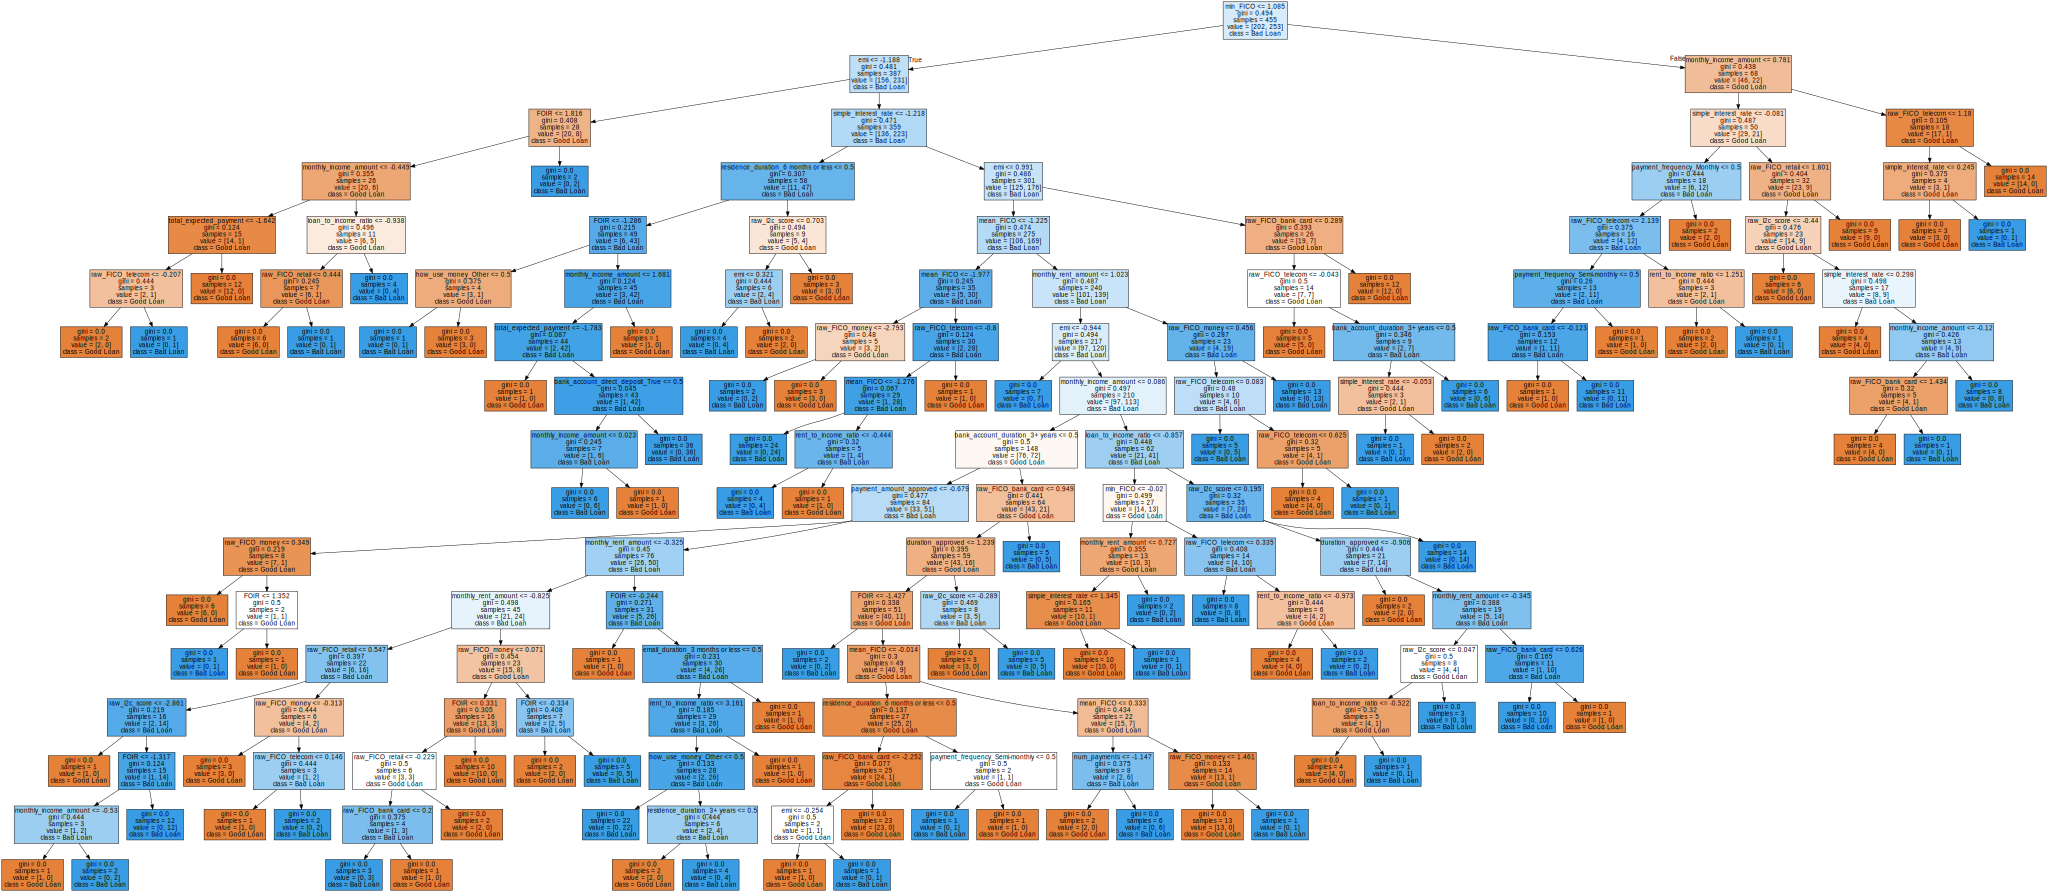

In [140]:
import graphviz
dot_data  = export_graphviz(dtree_base, 
                    feature_names=X_train_processed.columns,
                    class_names=['Good Loan', "Bad Loan"],
                    filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

##### 4.2.2 Hyper-parameter tuning Decision Trees

In [141]:
from sklearn.model_selection import RandomizedSearchCV

max_depth = list(range(3,6)) #[int(x) for x in np.linspace(3, 20, num = 11)]
#max_depth.append(None)
min_samples_split = [30, 60, 100]
min_samples_leaf = [5, 10, 20]
criterion = ["gini", "entropy"]

# Create the random grid
params = {'max_depth': max_depth, # Maximum number of levels in tree
          'min_samples_split': min_samples_split, # Minimum number of samples required to split a node
          'min_samples_leaf': min_samples_leaf, # Minimum number of samples required at each leaf node
          'criterion': criterion} # Method of selecting samples for training each tree

rskf = RepeatedStratifiedKFold(n_splits = 50 , n_repeats = 2, random_state = 42)
dt_cv = GridSearchCV(
  DecisionTreeClassifier(random_state=42), params, 
  cv = rskf, 
  scoring = 'roc_auc',
  verbose = True
)

dt_cv.fit(X_train_processed, y_train)
print(f'Best AUC-score: {dt_cv.best_score_:.3f}\n')
print(f'Best parameter set: {dt_cv.best_params_}\n')
print(f'Scores: \n{classification_report(y_train, dt_cv.predict(X_train_processed))}')
#report_classification_metrics(y_train, dt_cv.predict(X_train_processed), y_test, dt_cv.predict(X_test_processed))
report_classification_metrics(X_train_processed, y_train, X_test_processed, y_test, dt_cv.best_estimator_)

Fitting 100 folds for each of 54 candidates, totalling 5400 fits
Best AUC-score: 0.604

Best parameter set: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 60}

Scores: 
              precision    recall  f1-score   support

           0       0.70      0.42      0.52       202
           1       0.65      0.85      0.74       253

    accuracy                           0.66       455
   macro avg       0.67      0.64      0.63       455
weighted avg       0.67      0.66      0.64       455

Train set results
Accuracy  :  66.15%
F1-score  :  74.53%
ROC AUC   :  70.17%
AUPRC     :  76.25%

Test set results
Accuracy  :  60.53%
F1-score  :  71.09%
ROC AUC   :  63.56%
AUPRC     :  72.16%


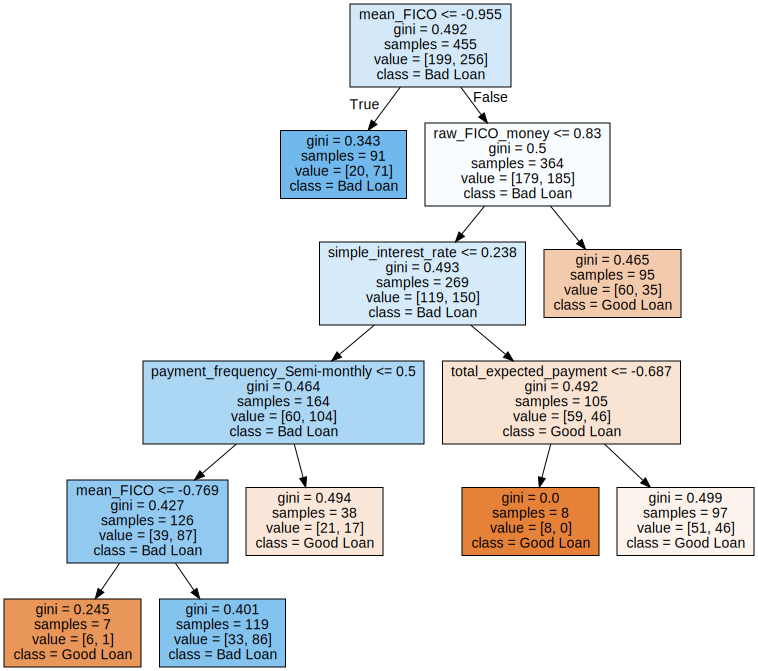

In [ ]:
dot_data  = export_graphviz(dt_cv.best_estimator_, 
                    feature_names=X_train_processed.columns,
                    class_names=['Good Loan', "Bad Loan"],
                    filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

##### 4.3 Random Forests



In [37]:
from random import random
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [10, 20, 30, 40, 50]
max_features = ['log2', 'sqrt']
max_depth = list(range(2,5)) #[int(x) for x in np.linspace(3, 20, num = 11)
# min_samples_split = [30, 60, 100]
# min_samples_leaf = [5, 10, 20]
min_samples_split = [20, 40, 80]
min_samples_leaf = [10, 20, 40]
max_samples = [0.75, 0.5]

# Create the random grid
random_grid = {'n_estimators': n_estimators, # Number of trees in random forest
               'max_features': max_features, # Number of features to consider at every split
               'max_depth': max_depth, # Maximum number of levels in tree
               'min_samples_split': min_samples_split, # Minimum number of samples required to split a node
               'min_samples_leaf': min_samples_leaf, # Minimum number of samples required at each leaf node
               'max_samples': max_samples} # Method of selecting samples for training each tree

rskf = RepeatedStratifiedKFold(n_splits = 50, n_repeats = 2, random_state = 42)

# rf_cv = GridSearchCV(
#   RandomForestClassifier(random_state = 42), random_grid, 
#   cv = rskf, 
#   scoring = 'roc_auc',
#   verbose = True
# )

rf_cv = RandomizedSearchCV(
  estimator = RandomForestClassifier(random_state= 42), 
  n_iter = 100,
  param_distributions = random_grid, 
  cv = rskf, 
  scoring = 'roc_auc',
  verbose= True
  )

rf_cv.fit(X_train_processed, y_train)

Fitting 100 folds for each of 100 candidates, totalling 10000 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=50, random_state=42),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [2, 3, 4],
                                        'max_features': ['log2', 'sqrt'],
                                        'max_samples': [0.75, 0.5],
                                        'min_samples_leaf': [10, 20, 40],
                                        'min_samples_split': [20, 40, 80],
                                        'n_estimators': [10, 20, 30, 40, 50]},
                   scoring='roc_auc', verbose=True)

In [38]:
print(f'Best AUC-score: {rf_cv.best_score_:.3f}\n')
print(f'Best parameter set: {rf_cv.best_params_}\n')
#report_classification_metrics(y_train, rf_cv.predict(X_train_processed), y_test, rf_cv.predict(X_test_processed))
report_classification_metrics(X_train_processed, y_train, X_test_processed, y_test, rf_cv.best_estimator_)

Best AUC-score: 0.626

Best parameter set: {'n_estimators': 20, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_samples': 0.5, 'max_features': 'log2', 'max_depth': 3}

Train set results
Accuracy  :  68.13%
F1-score  :  75.96%
ROC AUC   :  73.67%
AUPRC     :  79.14%

Test set results
Accuracy  :  63.16%
F1-score  :  72.99%
ROC AUC   :  65.10%
AUPRC     :  66.98%


##### 4.4.2 Extreme regularized model 

In [106]:
regularized_rf = RandomForestClassifier(
                    n_estimators = 120, 
                    min_samples_split = 50, 
                    min_samples_leaf = 20, 
                    max_depth = 5, 
                    max_samples = 0.75)

regularized_rf.fit(X_train_processed, y_train)
#report_classification_metrics(y_train, regularized_rf.predict(X_train_processed), y_test, regularized_rf.predict(X_test_processed))
report_classification_metrics(X_train_processed, y_train, X_test_processed, y_test, regularized_rf)

Train set results
Accuracy  :  70.99%
F1-score  :  76.16%
ROC AUC   :  76.52%
AUPRC     :  81.06%

Test set results
Accuracy  :  59.87%
F1-score  :  68.42%
ROC AUC   :  62.10%
AUPRC     :  67.24%


##### 4.4.3 Optuna Random Forest

In [101]:
import optuna
from sklearn import model_selection

#Step 1. Define an objective function to be maximized.
def objective(trial):
    
    # Setup values for the hyperparameters:
    max_samples = trial.suggest_float("max_samples", 0, 1)
    n_estimators = trial.suggest_int("n_estimators", 10, 500)
    min_samples_split = trial.suggest_int("min_samples_split", 5, 100)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 100)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    classifier_obj = RandomForestClassifier(n_estimators=n_estimators, 
                                        max_depth = max_depth,
                                        max_samples = max_samples, 
                                        min_samples_split = min_samples_split,
                                        min_samples_leaf = min_samples_leaf,
                                        random_state= 42)

    # Step 3: Scoring method:
    rskf = RepeatedStratifiedKFold(n_splits = 50, n_repeats = 2, random_state = 42)
    score = model_selection.cross_val_score(classifier_obj, X_train_processed, y_train, cv=rskf, scoring = 'roc_auc')
    auc = score.mean()
    return auc

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

[I 2022-10-30 19:38:33,372] A new study created in memory with name: no-name-4576cb29-4026-4e56-8495-3298918d8ed7
[I 2022-10-30 19:41:09,735] Trial 0 finished with value: 0.5 and parameters: {'max_samples': 0.2387752480788944, 'n_estimators': 399, 'min_samples_split': 49, 'min_samples_leaf': 89, 'max_depth': 4}. Best is trial 0 with value: 0.5.
[I 2022-10-30 19:44:03,426] Trial 1 finished with value: 0.6285000000000001 and parameters: {'max_samples': 0.6357687752626622, 'n_estimators': 278, 'min_samples_split': 71, 'min_samples_leaf': 25, 'max_depth': 17}. Best is trial 1 with value: 0.6285000000000001.
[I 2022-10-30 19:45:45,505] Trial 2 finished with value: 0.5 and parameters: {'max_samples': 0.029350097239891904, 'n_estimators': 179, 'min_samples_split': 61, 'min_samples_leaf': 17, 'max_depth': 11}. Best is trial 1 with value: 0.6285000000000001.
[I 2022-10-30 19:47:55,339] Trial 3 finished with value: 0.5 and parameters: {'max_samples': 0.10318580881827066, 'n_estimators': 232, 'mi

In [102]:
# Getting the best trial:
print(f"\nThe best trial is : \n{study.best_trial}")
print(f"\nThe best value is : \n{study.best_value}")

# Getting the best parameters:
print(f"\nThe best parameters are : \n{study.best_params}")


The best trial is : 
FrozenTrial(number=18, values=[0.6344722222222223], datetime_start=datetime.datetime(2022, 10, 30, 20, 5, 14, 43334), datetime_complete=datetime.datetime(2022, 10, 30, 20, 6, 15, 786098), params={'max_samples': 0.7760092690609344, 'n_estimators': 282, 'min_samples_split': 56, 'min_samples_leaf': 13, 'max_depth': 16}, distributions={'max_samples': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'n_estimators': IntDistribution(high=500, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=100, log=False, low=5, step=1), 'min_samples_leaf': IntDistribution(high=100, log=False, low=2, step=1), 'max_depth': IntDistribution(high=20, log=False, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=18, state=TrialState.COMPLETE, value=None)

The best value is : 
0.6344722222222223

The best parameters are : 
{'max_samples': 0.7760092690609344, 'n_estimators': 282, 'min_samples_split': 56, 'min_samples_leaf': 13, 'ma

In [103]:
optuna_rf = RandomForestClassifier(random_state = 42, max_samples = 0.7760092690609344, 
                                        min_samples_split = 56, 
                                        min_samples_leaf = 13,
                                        max_depth = 16).fit(X_train_processed, y_train)
report_classification_metrics(X_train = X_train_processed, 
                            y_train = y_train, 
                            X_test = X_test_processed, 
                            y_test = y_test, 
                            model = optuna_rf)

Train set results
Accuracy  :  70.99%
F1-score  :  77.47%
ROC AUC   :  77.96%
AUPRC     :  82.17%

Test set results
Accuracy  :  59.21%
F1-score  :  70.19%
ROC AUC   :  61.29%
AUPRC     :  66.43%


In [ ]:
# from sklearn.inspection import (partial_dependence, 
#                                 PartialDependenceDisplay)

# n_cols = 2
# n_rows = int(len(final_column_names)/n_cols)
# fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 12))
# PartialDependenceDisplay.from_estimator(best_rf_model, X_train_processed, X_train_processed.columns, ax=ax, n_cols=n_cols)
# fig.suptitle('Partial Dependence Plots')
# fig.tight_layout();

##### 4.4 XGBoost Classifier



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 21, num = 10)]
max_depth = [3, 4, 5, 6, 10]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

# Create the random grid
random_grid = {'n_estimators': n_estimators, # Number of trees in random forest
               'max_depth': max_depth, # Maximum number of levels in tree
              'subsample' : subsample, # Percentage of sample used in every tree fit
              #'clf__colsample_by_tree' : colsample_bytree, # percentage sampled for every tree  
              'colsample_bylevel' : colsample_bylevel, # percentage sampled for every level
               'learning_rate' : learning_rate # multiplier used in the gradients to move towards the optimized  
              }
rskf = RepeatedStratifiedKFold(n_splits = 25, n_repeats = 2, random_state = 42)
xgb_cv = RandomizedSearchCV(
  estimator = XGBClassifier(), 
  n_iter = 100,
  param_distributions = random_grid, 
  cv = rskf, 
  scoring = 'roc_auc',
  verbose= True
  )

xgb_cv.fit(X_train_processed, y_train)


Fitting 50 folds for each of 100 candidates, totalling 5000 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=25, random_state=42),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=Non...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 10],
                                        'n_estimators': [10, 11, 12, 13, 14, 16,
                                                         17, 18, 19, 21],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='roc_auc', verbose=True)

In [ ]:
print(f'Best AUC-score: {xgb_cv.best_score_:.3f}\n')
print(f'Best parameter set: {xgb_cv.best_params_}\n')
#report_classification_metrics(y_train, xgb_cv.predict(X_train_processed), y_test, xgb_cv.predict(X_test_processed))
report_classification_metrics(X_train_processed, y_train, X_test_processed, y_test, xgb_cv.best_estimator_)

Best AUC-score: 0.626

Best parameter set: {'subsample': 0.5, 'n_estimators': 16, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bylevel': 0.5}

Train set results
Accuracy  :  72.53%
Precision :  70.53%
Recall    :  87.89%
F1-score  :  78.26%
ROC AUC   :  70.33%

Test set results
Accuracy  :  58.55%
Precision :  60.58%
Recall    :  74.12%
F1-score  :  66.67%
ROC AUC   :  56.46%


Testing Optuna

In [ ]:
import optuna 
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

def objective(trial):
    dtrain = xgb.DMatrix(X_train_processed, label=y_train)
    dtest = xgb.DMatrix(X_test_processed, label=y_test)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    y_preds = bst.predict(dtest)
    pred_labels = np.rint(y_preds)
    auc = roc_auc_score(y_test, y_preds)
    return auc

##### 4.5 SVCs (Last Resort)

In [109]:
param_grid = {'C': [0.01, 0.001, 0.0001], 
              'gamma': [0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']} 

rskf = RepeatedStratifiedKFold(n_splits = 25, n_repeats = 2, random_state = 42)

svc_cv = GridSearchCV(
  SVC(random_state= 42, probability=True), param_grid, 
  cv = rskf, 
  scoring = 'roc_auc',
  verbose = True
  )

svc_cv.fit(X_train_processed, y_train)
print(f'Best AUC-score: {svc_cv.best_score_:.3f}\n')
print(f'Best parameter set: {svc_cv.best_params_}\n')
#report_classification_metrics(y_train, svc_cv.predict(X_train_processed), y_test, svc_cv.predict(X_test_processed))
report_classification_metrics(X_train_processed, y_train, X_test_processed, y_test, svc_cv.best_estimator_)

Fitting 50 folds for each of 27 candidates, totalling 1350 fits
Best AUC-score: 0.623

Best parameter set: {'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}

Train set results
Accuracy  :  65.93%
F1-score  :  72.56%
ROC AUC   :  65.80%
AUPRC     :  69.56%

Test set results
Accuracy  :  55.92%
F1-score  :  72.25%
ROC AUC   :  59.11%
AUPRC     :  66.01%


In [110]:
report_classification_metrics(X_train_processed, y_train, X_test_processed, y_test, svc_cv.best_estimator_)

Train set results
Accuracy  :  65.93%
F1-score  :  72.56%
ROC AUC   :  65.80%
AUPRC     :  69.56%

Test set results
Accuracy  :  55.92%
F1-score  :  72.25%
ROC AUC   :  59.11%
AUPRC     :  66.01%


##### 4.6 Plotting AUC curves

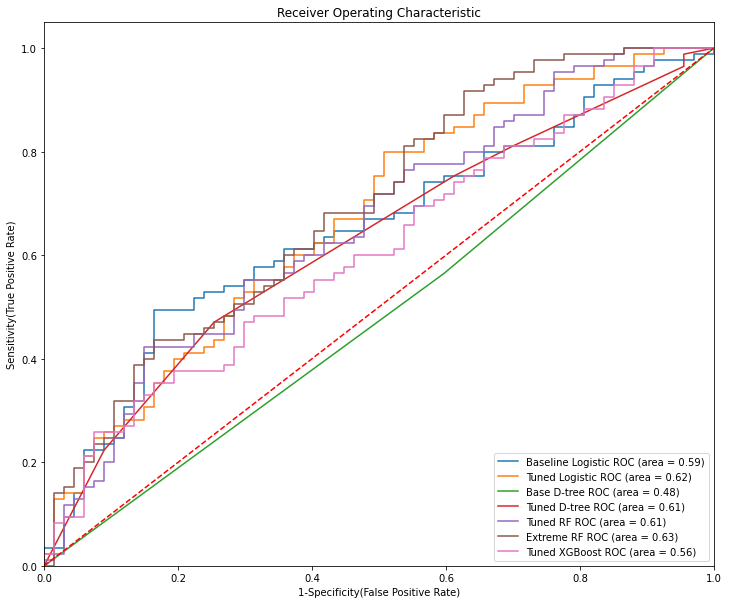

In [82]:
from sklearn import metrics

plt.figure(figsize = (12,10))

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Baseline Logistic',
    'model': lr_base,
},
{
    'label': 'Tuned Logistic',
    'model': logreg_cv.best_estimator_,
},
{
    'label': 'Base D-tree',
    'model': dtree_base,
},
{
    'label': 'Tuned D-tree',
    'model': dt_cv.best_estimator_,
},
{
    'label': 'Tuned RF',
    'model': rf_cv.best_estimator_,
},
{
    'label': 'Extreme RF',
    'model': regularized_rf,
},
{
    'label': 'Tuned XGBoost',
    'model': xgb_cv.best_estimator_,
}
#,
#{
#    'label': 'Tuned SVC',
#    'model': svc_cv.best_estimator_,
#}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    #model.fit(X_train_processed, y_train) # train the model
    y_pred=model.predict(X_test_processed) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test_processed)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test_processed))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

##### 4.7 Plotting AUPRC curves

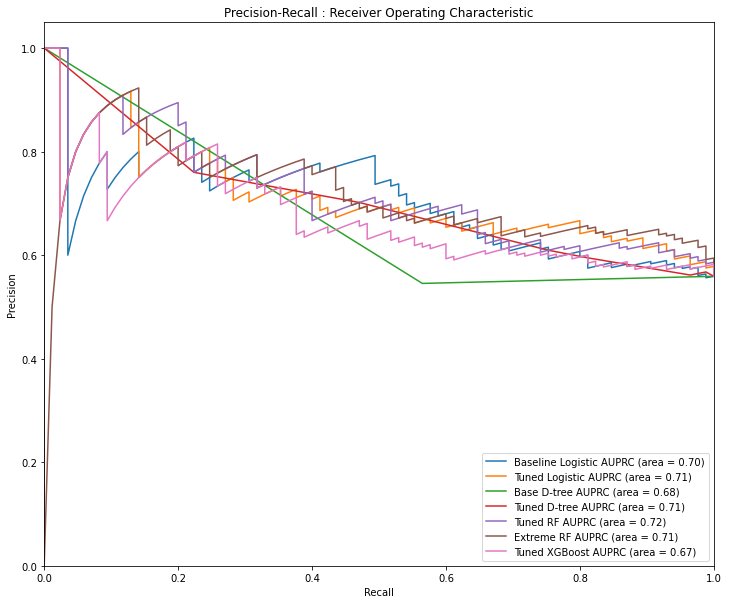

In [87]:
from sklearn import metrics

plt.figure(figsize = (12,10))

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    #model.fit(X_train_processed, y_train) # train the model
    y_pred=model.predict(X_test_processed) # predict the test data
# Compute False postive rate, and True positive rate
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, model.predict_proba(X_test_processed)[:,1])
    #fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test_processed)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.auc(recall, precision)
# Now, plot the computed values
    plt.plot(recall, precision, label='%s AUPRC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall : Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

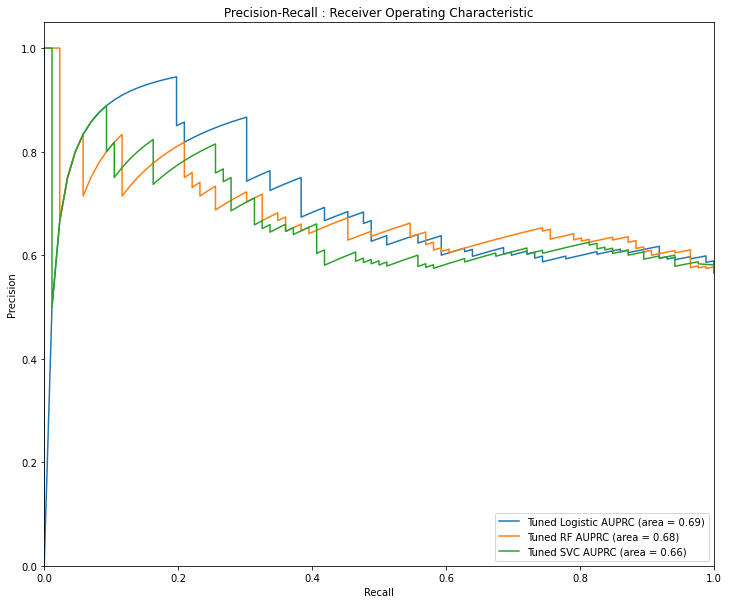

In [112]:
from sklearn import metrics

plt.figure(figsize = (12,10))
models = [
{
    'label': 'Tuned Logistic',
    'model': logreg_cv.best_estimator_,
},
{
    'label': 'Tuned RF',
    'model': rf_cv.best_estimator_,
},
{
   'label': 'Tuned SVC',
   'model': svc_cv.best_estimator_,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    #model.fit(X_train_processed, y_train) # train the model
    y_pred=model.predict(X_test_processed) # predict the test data
# Compute False postive rate, and True positive rate
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, model.predict_proba(X_test_processed)[:,1])
    #fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test_processed)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.auc(recall, precision)
# Now, plot the computed values
    plt.plot(recall, precision, label='%s AUPRC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall : Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

#### Model Explainability

##### 5.1 Partial Dependency Plots

In [41]:
def pdp(var, df, model):
    values = df[var].sort_values().unique()
    individual = np.empty((len(df), len(values)))
    for i, value in enumerate(values):
        df_copy = df.copy()
        df_copy[var] = value
        individual[:, i] = model.predict_proba(df_copy)[:, 1]
    return values, individual.mean(axis=0)

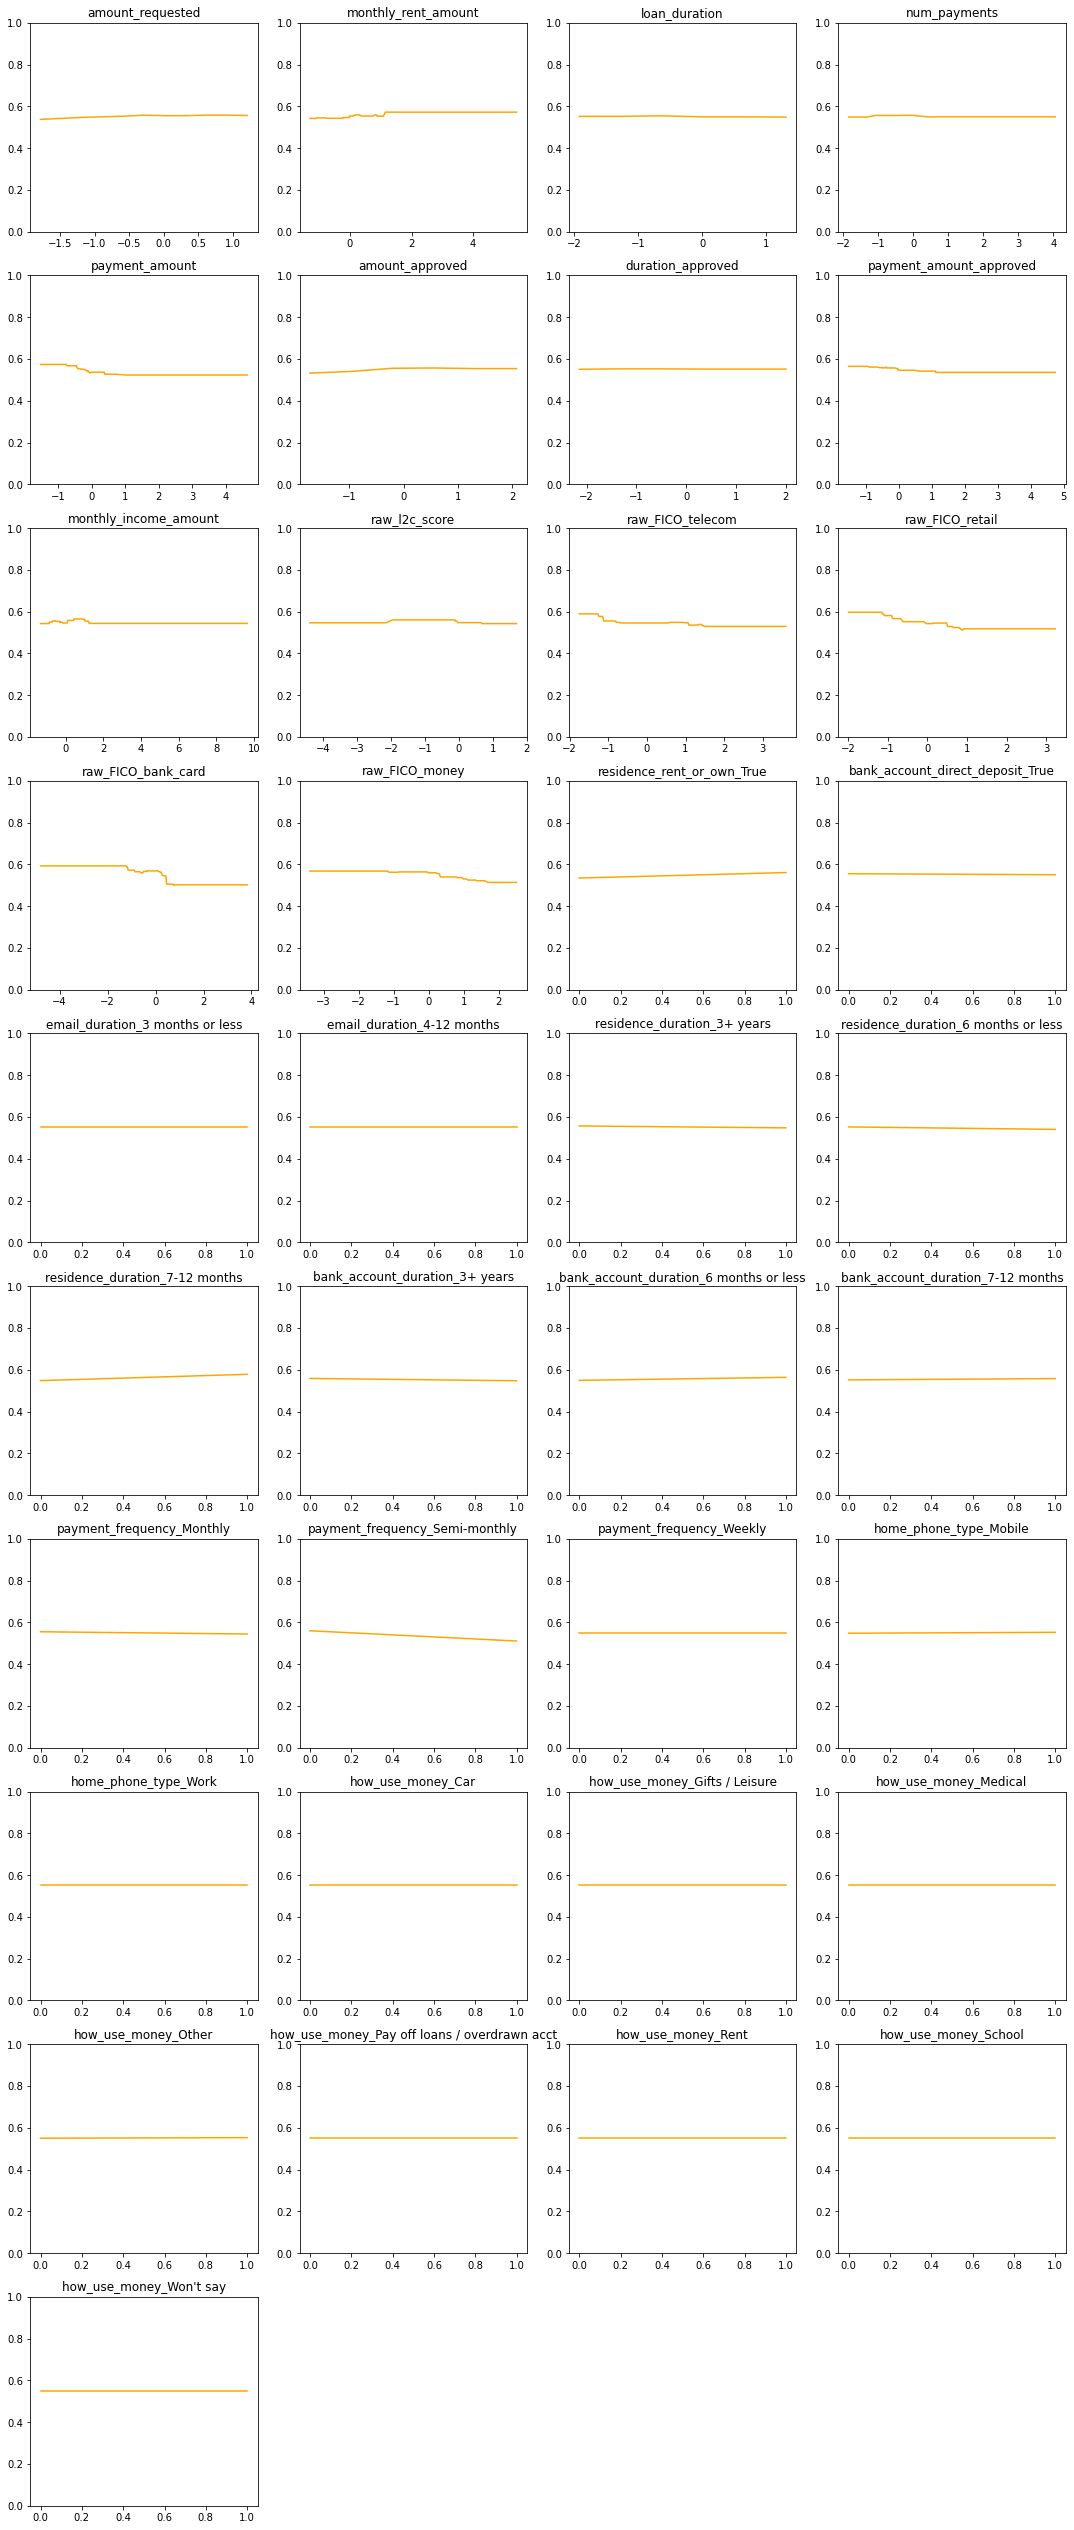

In [ ]:
n_cols = 4
n_rows = int(len(X_train_processed)/n_cols) + 1
fig = plt.figure(figsize = (15, 400))
for i,col in enumerate(X_train_processed.columns):
    values, pdp_values = pdp(var = col, df = X_train_processed, model = rf_cv.best_estimator_)
    ax = fig.add_subplot(n_rows,n_cols,i + 1)
    ax.plot(values, pdp_values, color = 'orange')
    ax.set_ylim([0, 1])  
    ax.set_title(col)

plt.tight_layout()
plt.show()

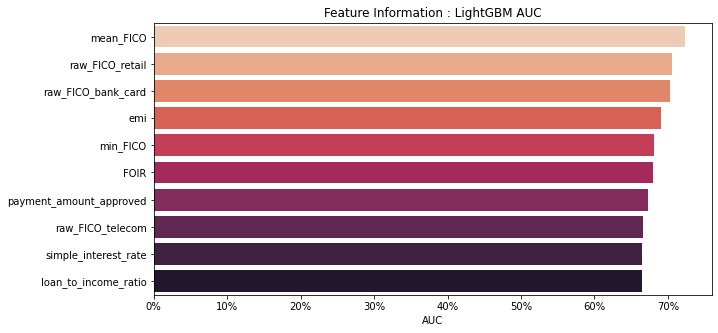

In [39]:
from preprocessing import FeatureInformation

feature_imp = FeatureInformation(input_data = customer_data , 
                                        feature_list = input_features, 
                                        target = 'target', 
                                        method = 'lgbm')
feature_imp.plot()

In [ ]:
X_train_processed.columns

Index(['amount_requested', 'monthly_rent_amount', 'loan_duration',
       'num_payments', 'payment_amount', 'amount_approved',
       'duration_approved', 'payment_amount_approved', 'monthly_income_amount',
       'raw_l2c_score', 'raw_FICO_telecom', 'raw_FICO_retail',
       'raw_FICO_bank_card', 'raw_FICO_money', 'residence_rent_or_own_True',
       'bank_account_direct_deposit_True', 'email_duration_3 months or less',
       'email_duration_4-12 months', 'residence_duration_3+ years',
       'residence_duration_6 months or less', 'residence_duration_7-12 months',
       'bank_account_duration_3+ years',
       'bank_account_duration_6 months or less',
       'bank_account_duration_7-12 months', 'payment_frequency_Monthly',
       'payment_frequency_Semi-monthly', 'payment_frequency_Weekly',
       'home_phone_type_Mobile', 'home_phone_type_Work', 'how_use_money_Car',
       'how_use_money_Gifts / Leisure', 'how_use_money_Medical',
       'how_use_money_Other', 'how_use_money_Pay off

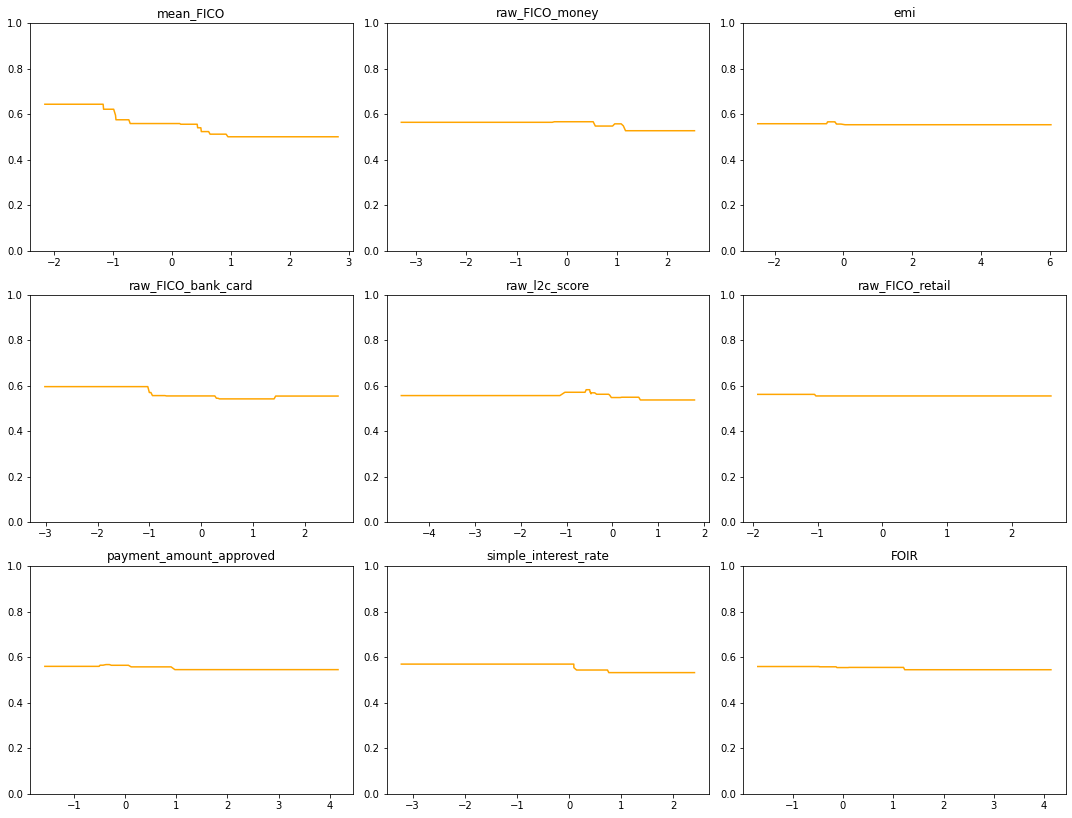

In [43]:
reqd_cols = ['mean_FICO','raw_FICO_money', 'emi', 'raw_FICO_bank_card', 
        'raw_l2c_score', 'raw_FICO_retail', 'payment_amount_approved', 'simple_interest_rate', 'FOIR']
n_cols = 3
n_rows = int(len(reqd_cols)/n_cols) + 1
fig = plt.figure(figsize = (15, 15))
for i,col in enumerate(X_train_processed[reqd_cols].columns):
    values, pdp_values = pdp(var = col, df = X_train_processed, model = rf_cv.best_estimator_)
    ax = fig.add_subplot(n_rows,n_cols,i + 1)
    ax.plot(values, pdp_values, color = 'orange')
    ax.set_ylim([0, 1])  
    ax.set_title(col)

plt.tight_layout()
plt.show()

##### 5.2 SHAPley values

In [44]:
import shap
explainer = shap.TreeExplainer(model = rf_cv.best_estimator_,
                              data = X_test_processed,
                              model_output = 'probability')
# explainer = shap.TreeExplainer(model = rf_cv.best_estimator_,
#                                 model_output = 'probabiltity')
shap_values = explainer.shap_values(X_test_processed)


In [45]:
print(f'Shape of test dataset : {X_test_processed.shape}')
print(f'Shape of SHAP values : {np.array(shap_values).shape}')

Shape of test dataset : (152, 40)
Shape of SHAP values : (2, 152, 40)


SHAP for a random observation

In [51]:
choosen_instance = X_test_processed.iloc[5,:]
shap_values_instance = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_instance[1], choosen_instance)

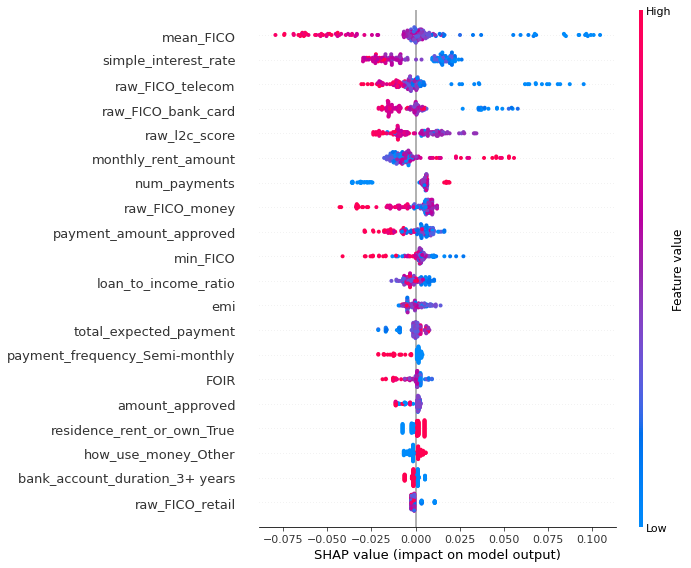

In [52]:
shap.summary_plot(shap_values[1], features = X_test_processed, class_inds=[1])